Dropped 5549 rows due to missing lookback data; remaining 67945 rows.
Dropped 333 rows due to missing forward ret_p_p1..p10 data; remaining 67612 rows.
Number of features after excluding future cols: 97
Train dates: 02/20/2024 → 12/28/2018
Test dates:  07/22/2025 → 02/16/2024
Target distribution (pos rate):
any_pos_next10
True     0.810625
False    0.189375
Name: proportion, dtype: float64
Train shape: (54039, 97) Test shape: (13622, 97)
[[   64  2545]
 [   91 10922]]
              precision    recall  f1-score   support

           0       0.41      0.02      0.05      2609
           1       0.81      0.99      0.89     11013

    accuracy                           0.81     13622
   macro avg       0.61      0.51      0.47     13622
weighted avg       0.73      0.81      0.73     13622

ROC AUC: 0.5699151081667064


C:\Users\John DeForest\AppData\Local\Temp\ipykernel_64116\3299573796.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=fi, palette="viridis")


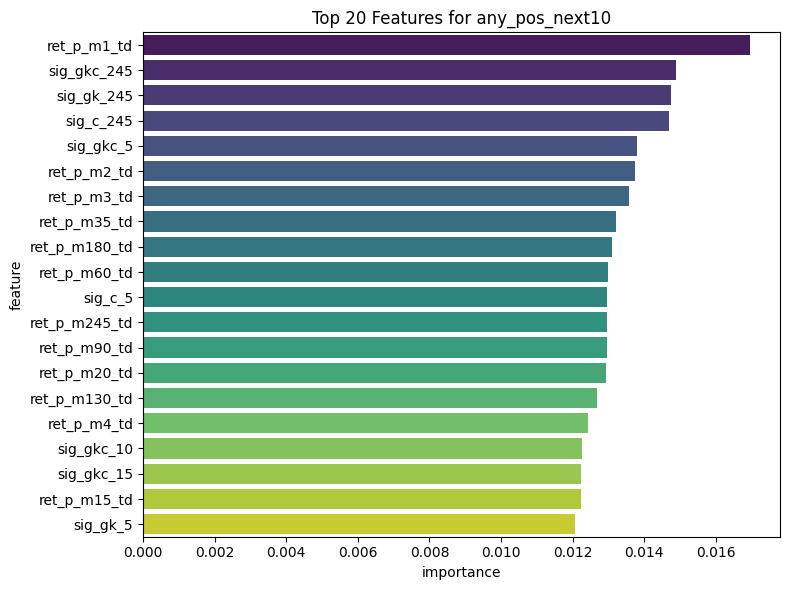

blocRuntime 94.5s


In [ ]:
#dr3
import re
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

starttime = time.time()
# --- Config ---
CSV_IN = "oip_mega_wretvol.csv"
x_days = 10

# --- Load ---
df = pd.read_csv(CSV_IN)
original_row_count = len(df)

# --- Forward columns (target lookahead) ---
forward_cols = [f"ret_p_p{i}_td" for i in range(1, x_days+1)]
forward_cols = [c for c in forward_cols if c in df.columns]
if len(forward_cols) != x_days:
    raise ValueError(f"Expected {x_days} forward columns but found {len(forward_cols)}: {forward_cols}")

# --- Lookback columns (must be present, drop rows missing these) ---
lookback_cols = [c for c in df.columns if (c.startswith("p_m") or c.startswith("v_m") or c.startswith("ret_p_m")) and "_td" in c]
if len(lookback_cols) == 0:
    raise ValueError("No lookback columns found (p_m*, v_m*, ret_p_m*).")

df = df.dropna(subset=lookback_cols)
print(f"Dropped {original_row_count - len(df)} rows due to missing lookback data; remaining {len(df)} rows.")

# --- Build target: any positive return in next x days ---
df["any_pos_next10"] = df[forward_cols].gt(0).any(axis=1)

# --- Drop rows missing any of the first x forward returns (you requested this) ---
before_forward_drop = len(df)
df = df.dropna(subset=forward_cols)
print(f"Dropped {before_forward_drop - len(df)} rows due to missing forward ret_p_p1..p{ x_days } data; remaining {len(df)} rows.")

# --- Build feature list: exclude any future-looking columns (regex) and metadata ---
# Regex patterns to exclude future-looking features (p_p*, ret_p_p*, v_p*)
future_regex = [r"^p_p\d+_td$", r"^ret_p_p\d+_td$", r"^v_p\d+_td$"]

# Static columns to exclude
meta_exclude = {
    "filing_date", "trade_date", "ticker", "company_name",
    "insider_name", "title", "trade_type", "mebuydate",
    "any_pos_next10"  # exclude target
}

def is_future_col(col):
    for pat in future_regex:
        if re.match(pat, col):
            return True
    return False

# Keep past returns/vols/prices (p_m*, v_m*, ret_p_m*) and other engineered features,
# but exclude *any* future p_p*, ret_p_p*, v_p*.
candidate_features = [c for c in df.columns if c not in meta_exclude and not is_future_col(c)]

# Ensure we didn't accidentally keep forward columns:
candidate_features = [c for c in candidate_features if c not in forward_cols]

# Keep only numeric/bool columns
X_all = df[candidate_features].select_dtypes(include=[np.number, bool])

# Final feature list (columns actually used)
features = list(X_all.columns)
print(f"Number of features after excluding future cols: {len(features)}")

# Sanity check: assert no forward cols in features
assert not any(re.match(r"^ret_p_p\d+_td$", f) or re.match(r"^p_p\d+_td$", f) or re.match(r"^v_p\d+_td$", f) for f in features), \
    "Forward-looking columns still present in features! Aborting."

# --- Prepare X, y ---
# --- Ensure datetime ---
df["filing_date"] = pd.to_datetime(df["filing_date"])
df["trade_date"]  = pd.to_datetime(df["trade_date"])  # optional, if you want trade_date info

# --- Define train/test cutoff dates ---
train_end = pd.Timestamp("2024-02-21")
test_start = pd.Timestamp("2024-02-21")
test_end   = pd.Timestamp("2025-07-22")

# --- Split by filing_date ---
train_mask = df["filing_date"] <= train_end
test_mask  = (df["filing_date"] >= test_start) & (df["filing_date"] <= test_end)

X_train = X_all.loc[train_mask].copy()
y_train = df.loc[train_mask, "any_pos_next10"].astype(int)

X_test = X_all.loc[test_mask].copy()
y_test = df.loc[test_mask, "any_pos_next10"].astype(int)

# --- Print summary ---
print(f"Train dates: {df.loc[train_mask, 'trade_date'].iloc[0].strftime('%m/%d/%Y')} → "
      f"{df.loc[train_mask, 'trade_date'].iloc[-1].strftime('%m/%d/%Y')}")
print(f"Test dates:  {df.loc[test_mask, 'trade_date'].iloc[0].strftime('%m/%d/%Y')} → "
      f"{df.loc[test_mask, 'trade_date'].iloc[-1].strftime('%m/%d/%Y')}")

# --- Show class balance ---
print("Target distribution (pos rate):")
print(df["any_pos_next10"].value_counts(normalize=True))

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# --- Quick model ---
model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# --- Eval ---
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
# --- Feature importance (top 20) ---
fi = pd.DataFrame({
    "feature": features,  # use the final feature list
    "importance": model.feature_importances_
})
fi = fi.sort_values("importance", ascending=False).head(20)

plt.figure(figsize=(8, 6))
sns.barplot(x="importance", y="feature", data=fi, palette="viridis")
plt.title(f"Top 20 Features for any_pos_next{x_days}")
plt.tight_layout()
plt.show()
print(f'blocRuntime {round(time.time()-starttime,1)}s')

In [44]:
# print(len(y_pred))
# X_test.index
# Boolean mask for predicted positives
mask = y_pred == 1

# Indices in X_test corresponding to predicted positive trades
pred_pos_indices = X_test.index[mask]

print("Number of predicted positive trades:", len(pred_pos_indices))
print(pred_pos_indices)

Number of predicted positive trades: 13467
Index([  351,   352,   353,   354,   355,   356,   357,   358,   359,   360,
       ...
       14732, 14733, 14734, 14736, 14737, 14738, 14739, 14740, 14741, 14742],
      dtype='int64', length=13467)


In [154]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def simulate_recent_trades(og_csv_path, test_indices, y_test, nt=10, nd=5, invest_per_trade=100, plot=False):
    """
    Simulate trades for the most recent nt positive predictions in the test set.

    Parameters
    ----------
    og_csv_path : str
        Path to original CSV with full price data.
    test_indices : pd.Index
        Row indices from the original CSV corresponding to X_test.
    y_test : pd.Series
        Model predictions for X_test (1 if positive).
    nt : int
        Number of most recent trades to simulate.
    nd : int
        Holding period in days.
    invest_per_trade : float
        Amount to invest per trade.
    plot : bool
        Whether to plot trade price paths.
    """
    
    # Load original CSV
    df_full = pd.read_csv(og_csv_path)
    df_full.index = df_full.index.astype(int)
    
    # Filter test trades
    df_test = df_full.loc[test_indices].copy()
    
    # Keep only predicted positive trades
    df_test_pos = df_test[y_test == 1].copy()
    
    # Sort by filing_date descending
    df_test_pos['filing_date'] = pd.to_datetime(df_test_pos['filing_date'])
    df_test_pos = df_test_pos.sort_values('filing_date', ascending=False)
    
    # Most recent nt trades
    recent_trades = df_test_pos.head(nt)
    
    results = []
    
    for trade_id, row in recent_trades.iterrows():
        # Use the precomputed buy price and buy date from the original CSV
        buy_price = row['mebuy_price']
        buy_date = row['mebuydate']
        sell_price = row.get(f'p_p{nd}_td', np.nan)
        
        if pd.isna(buy_price) or pd.isna(sell_price):
            continue
        
        shares = invest_per_trade / buy_price
        pnl = (sell_price - buy_price) * shares
        
        # Build price path
        prices = []
        labels = []
        # Lookback prices (last nd days before buy)
        lookback_cols = sorted([c for c in df_full.columns if c.startswith('p_m') and '_td' in c])
        lookback_cols = lookback_cols[-nd:]
        for i, col in enumerate(lookback_cols):
            prices.append(row.get(col, np.nan))
            labels.append(-nd + i)
        
        # Buy price
        prices.append(buy_price)
        labels.append(0)
        
        # Forward prices
        for i in range(1, nd+1):
            col = f'p_p{i}_td'
            prices.append(row.get(col, np.nan))
            labels.append(i)
        sell_date = (pd.to_datetime(row['mebuydate']) + pd.offsets.BDay(nd)).strftime('%Y-%m-%d')

        # Plot
        if plot:
            plt.figure(figsize=(6,4))
            plt.plot(labels, prices, marker='o', color='gray', alpha=0.7)
            plt.plot(0, buy_price, 'go', label='Buy')
            plt.plot(nd, sell_price, 'ro', label='Sell')
            plt.plot([0, nd], [buy_price, sell_price],
                     color='green' if pnl>=0 else 'red', linewidth=2)
            plt.title(f"${row['ticker']},Filed {row['filing_date'].strftime('%Y-%m-%d')},"
                      f"\nB {buy_price:.2f},{buy_date}→S {sell_price:.2f},{sell_date}|PnL ${pnl:.2f}/{invest_per_trade}")
            plt.xlabel("Days relative to buy")
            plt.ylabel("Price")
            plt.legend()
            plt.tight_layout()
            plt.show()
        
        results.append({
            "trade_id": trade_id,
            "ticker": row['ticker'],
            "filing_date": row['filing_date'],
            "buy_date": buy_date,
            "sell_date": (pd.to_datetime(row['mebuydate']) + pd.offsets.BDay(nd)).strftime('%Y-%m-%d'),
            "buy_price": buy_price,
            "sell_price": sell_price,
            "PnL_$": round(pnl,2)
        })
    
    results_df = pd.DataFrame(results)
    print(results_df)
    print(f"Total PnL: ${results_df['PnL_$'].sum():.2f}")
    return results_df
res =simulate_recent_trades(
    og_csv_path="oip_mega_wretvol.csv",
    test_indices=X_test.index,
    y_test=y_test,  # model predictions
    nt=1000,
    nd=7,
    invest_per_trade=1,
    plot=False
)
num_wins = (res["PnL_$"] > 0).sum()
total_trades = len(res)
win_pct = num_wins / total_trades * 100
print(f"Winning trades: {num_wins}/{total_trades} → Win %: {win_pct:.2f}%")


     trade_id ticker filing_date   buy_date   sell_date  buy_price  \
0         352   BRCC  2025-07-22  7/23/2025  2025-08-01       1.97   
1         360    RVP  2025-07-22  7/23/2025  2025-08-01       0.69   
2         363   STRW  2025-07-22  7/23/2025  2025-08-01      10.39   
3         362   GALT  2025-07-22  7/23/2025  2025-08-01       2.82   
4         361    TPL  2025-07-22  7/23/2025  2025-08-01     931.28   
..        ...    ...         ...        ...         ...        ...   
995      1570   PROP  2025-05-29  5/30/2025  2025-06-10       3.87   
996      1572   SHEN  2025-05-29  5/30/2025  2025-06-10      12.58   
997      1573   SHEN  2025-05-29  5/30/2025  2025-06-10      12.58   
998      1574    GLP  2025-05-29  5/30/2025  2025-06-10      52.52   
999      1576   MATX  2025-05-29  5/30/2025  2025-06-10     112.85   

     sell_price  PnL_$  
0          1.64  -0.17  
1          0.74   0.07  
2         10.19  -0.02  
3          3.65   0.29  
4        934.80   0.00  
..       

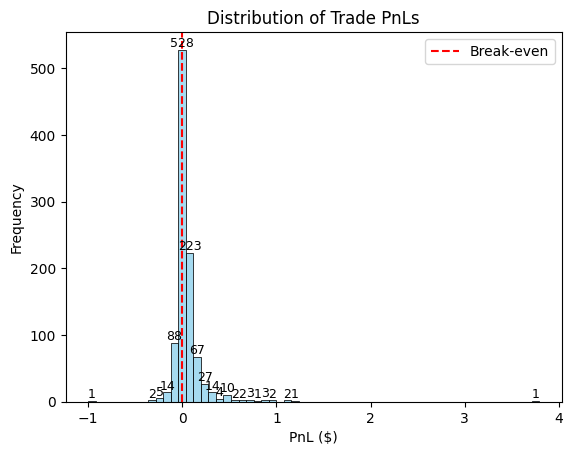

In [157]:
import seaborn as sns
import matplotlib.pyplot as plt
data = res["PnL_$"]
ax = sns.histplot(data, bins=60, kde=False, color="skyblue", edgecolor="black")
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', fontsize=9)
plt.axvline(0, color="red", linestyle="--", label="Break-even")
plt.xlabel("PnL ($)")
plt.ylabel("Frequency")
plt.title("Distribution of Trade PnLs")
plt.legend()
plt.show()

     trade_id ticker filing_date   buy_date   sell_date  buy_price  \
0         352   BRCC  2025-07-22  7/23/2025  2025-08-01      1.970   
1         363   STRW  2025-07-22  7/23/2025  2025-08-01     10.390   
2         362   GALT  2025-07-22  7/23/2025  2025-08-01      2.820   
3         361    TPL  2025-07-22  7/23/2025  2025-08-01    931.280   
4         353   BXSY  2025-07-22  7/23/2025  2025-08-01     13.670   
..        ...    ...         ...        ...         ...        ...   
995      1588   MNTR  2025-05-29  5/30/2025  2025-06-10      0.040   
996      1586   TOON  2025-05-29  5/30/2025  2025-06-10      0.824   
997      1584   DLPN  2025-05-29  5/30/2025  2025-06-10      1.070   
998      1592   TOON  2025-05-29  5/30/2025  2025-06-10      0.824   
999      1576   MATX  2025-05-29  5/30/2025  2025-06-10    112.850   

     sell_price  PnL_$  
0          1.64  -0.17  
1         10.19  -0.02  
2          3.65   0.29  
3        934.80   0.00  
4         13.42  -0.02  
..       

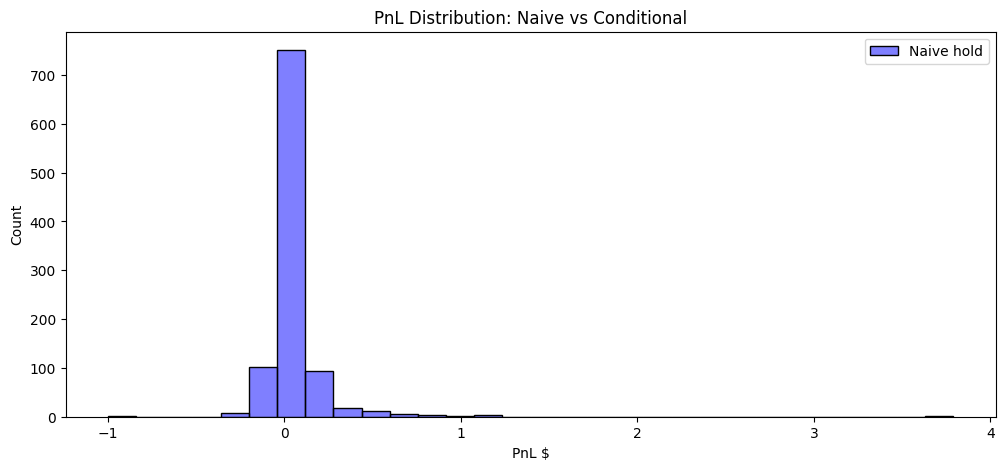

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
# --- Load original CSV ---
og_csv_path = "oip_mega_wretvol.csv"
df_full = pd.read_csv(og_csv_path)
df_full.index = df_full.index.astype(int)
# --- Parameters ---
nt = 1000                  # Number of most recent trades to simulate
hold_days = 7            # Naive hold duration
invest_per_trade = 1
horizon = 10             # Conditional sell horizon
threshold = 0.5          # RF threshold for conditional sell
# --- Pull test trades from X_test and y_test ---
df_test = df_full.loc[X_test.index].copy()
df_test['y_pred'] = y_test.values
# --- Keep only predicted positive trades ---
df_test_pos = df_test[df_test['y_pred'] == 1].copy()
df_test_pos['filing_date'] = pd.to_datetime(df_test_pos['filing_date'])
df_test_pos = df_test_pos.sort_values('filing_date', ascending=False)
# --- Most recent nt trades for simulation ---
recent_trades = df_test_pos.head(nt)

# --- Simulate naive hold trades ---
results_naive = simulate_recent_trades(
    og_csv_path=og_csv_path,
    test_indices=recent_trades.index,
    y_test=recent_trades['y_pred'],
    nt=nt,
    nd=hold_days,
    invest_per_trade=invest_per_trade,
    plot=False
)
print(f'finNaive')

# --- Compare results ---
print(f'naive hold {hold_days}d')
win_rate_naive = (results_naive["PnL_$"] > 0).mean()
#win_rate_cond = (results_cond["PnL_$"] > 0).mean()
print(f"Naive hold win rate: {win_rate_naive:.4f}")
#print(f"Conditional sell win rate: {win_rate_cond:.4f}")

# --- Plot PnL distributions ---
plt.figure(figsize=(12,5))
sns.histplot(results_naive["PnL_$"], bins=30, color='blue', alpha=0.5, label='Naive hold')
#sns.histplot(results_cond["PnL_$"], bins=30, color='green', alpha=0.5, label='Conditional sell')
plt.xlabel("PnL $")
plt.ylabel("Count")
plt.title("PnL Distribution: Naive vs Conditional")
plt.legend()
plt.show()


In [161]:
# --- Total PnL ---
total_pnl_naive = results_naive["PnL_$"].sum()
cutoff = .55
total_pnl_naive_minusposoutliers = results_naive[results_naive['PnL_$']<cutoff]['PnL_$'].sum()
print(f"Total Naive PnL w/o outliers> {cutoff}: ${total_pnl_naive_minusposoutliers:,.2f}")
print(f"Total Naive PnL: ${total_pnl_naive:,.2f}")
# --- Average PnL per trade ---
avg_pnl_naive = results_naive["PnL_$"].mean()
print(f"Average Naive PnL per trade: ${avg_pnl_naive:,.2f}")
print("\nTop 5 Naive Trades by PnL:")
print(results_naive.sort_values("PnL_$", ascending=False).head())


Total Naive PnL w/o outliers> 0.55: $28.52
Total Naive PnL: $45.62
Average Naive PnL per trade: $0.05

Top 5 Naive Trades by PnL:
     trade_id ticker filing_date   buy_date   sell_date  buy_price  \
798      1372   BSAI  2025-06-04   6/5/2025  2025-06-16   0.606025   
95        474   PAPL  2025-07-10  7/11/2025  2025-07-22   1.600000   
108       492   PAPL  2025-07-08   7/9/2025  2025-07-18   1.500000   
16        373   NEGG  2025-07-21  7/22/2025  2025-07-31  30.530000   
127       533   BSPK  2025-07-03   7/7/2025  2025-07-16   0.115900   

     sell_price  PnL_$  
798       2.900   3.79  
95        3.500   1.19  
108       3.150   1.10  
16       63.790   1.09  
127       0.225   0.94  


In [150]:
import pandas as pd
import numpy as np

# --- Step 0: Helper functions ---

def compute_next_day_and_future_returns_from_forward(df, x_days=10):
    """
    df: DataFrame must contain 'ret_p_p1_td' ... 'ret_p_p{x_days}_td'
    Returns: adds columns 'next_day_return' and 'future_max_return'
    """
    df = df.copy()
    forward_cols = [f"ret_p_p{i}_td" for i in range(1, x_days+1)]
    
    # Next-day return relative to mebuy price
    df['next_day_return'] = df[forward_cols[0]]
    
    # Max future return within horizon
    df['future_max_return'] = df[forward_cols].max(axis=1)
    
    return df

def build_frequency_table(df, bins=np.arange(-0.05, 0.051, 0.005), p_hold_threshold=0.5):
    """
    Build frequency-based conditional hold/sell table
    """
    df = df.copy()
    df['return_bin'] = pd.cut(df['next_day_return'], bins)
    
    freq_table = df.groupby('return_bin').apply(
        lambda x: pd.Series({
            'frac_future_higher': (x['future_max_return'] > x['next_day_return']).mean(),
            'mean_future_return': x['future_max_return'].mean()
        })
    ).reset_index()
    
    freq_table['decision'] = np.where(freq_table['frac_future_higher'] > p_hold_threshold, 'hold', 'sell')
    return freq_table

def get_bin_decision(freq_table, next_day_return):
    """
    Lookup the decision from frequency table given next-day return
    """
    row = freq_table[freq_table['return_bin'].apply(lambda b: b.left <= next_day_return < b.right)]
    if row.empty:
        return 'sell'  # default
    return row['decision'].values[0]

# --- Step 1: Prepare conditional training data ---
import pandas as pd
import numpy as np
import re

# --- Parameters ---
x_days = 10  # horizon for target lookahead

# --- Load main df ---
df = pd.read_csv(CSV_IN)
original_row_count = len(df)

# --- Forward columns (target lookahead) ---
forward_cols = [f"ret_p_p{i}_td" for i in range(1, x_days+1)]
forward_cols = [c for c in forward_cols if c in df.columns]
if len(forward_cols) != x_days:
    raise ValueError(f"Expected {x_days} forward columns but found {len(forward_cols)}: {forward_cols}")

# --- Lookback columns ---
lookback_cols = [c for c in df.columns if (c.startswith("p_m") or c.startswith("v_m") or c.startswith("ret_p_m")) and "_td" in c]
if len(lookback_cols) == 0:
    raise ValueError("No lookback columns found (p_m*, v_m*, ret_p_m*).")

# Drop rows missing lookbacks
df = df.dropna(subset=lookback_cols)
print(f"Dropped {original_row_count - len(df)} rows due to missing lookback data; remaining {len(df)} rows.")

# --- Build target: any positive return in next x days ---
df["any_pos_next10"] = df[forward_cols].gt(0).any(axis=1)

# Drop rows missing forward returns
before_forward_drop = len(df)
df = df.dropna(subset=forward_cols)
print(f"Dropped {before_forward_drop - len(df)} rows due to missing forward ret_p_p1..p{ x_days } data; remaining {len(df)} rows.")

# --- Build features, exclude future-looking and metadata ---
future_regex = [r"^p_p\d+_td$", r"^ret_p_p\d+_td$", r"^v_p\d+_td$"]
meta_exclude = {
    "filing_date", "trade_date", "ticker", "company_name",
    "insider_name", "title", "trade_type", "mebuydate",
    "any_pos_next10"
}

def is_future_col(col):
    for pat in future_regex:
        if re.match(pat, col):
            return True
    return False

candidate_features = [c for c in df.columns if c not in meta_exclude and not is_future_col(c)]
candidate_features = [c for c in candidate_features if c not in forward_cols]

# Keep only numeric/bool columns
X_all = df[candidate_features].select_dtypes(include=[np.number, bool])
features = list(X_all.columns)
print(f"Number of features after excluding future cols: {len(features)}")

assert not any(re.match(r"^ret_p_p\d+_td$", f) or re.match(r"^p_p\d+_td$", f) or re.match(r"^v_p\d+_td$", f) for f in features), \
    "Forward-looking columns still present in features! Aborting."

# --- Ensure datetime ---
df["filing_date"] = pd.to_datetime(df["filing_date"])
df["trade_date"]  = pd.to_datetime(df["trade_date"])  # optional

# --- Train/test split ---
train_end = pd.Timestamp("2024-02-21")
test_start = pd.Timestamp("2024-02-21")
test_end   = pd.Timestamp("2025-07-22")

train_mask = df["filing_date"] <= train_end
test_mask  = (df["filing_date"] >= test_start) & (df["filing_date"] <= test_end)

X_train = X_all.loc[train_mask].copy()
y_train = df.loc[train_mask, "any_pos_next10"].astype(int)

X_test = X_all.loc[test_mask].copy()
y_test = df.loc[test_mask, "any_pos_next10"].astype(int)

# --- Add first-tier predictions to df_train and df_test ---
# Replace the next line with your actual model predict call if needed
from sklearn.ensemble import RandomForestClassifier

# Example: train first-tier RF model (already done in your workflow)
rf_clf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_clf.fit(X_train, y_train)

df.loc[train_mask, "y_pred"] = rf_clf.predict(X_train)
df.loc[test_mask,  "y_pred"] = rf_clf.predict(X_test)

# --- Training set for conditional model ---
df_train_conditional = df.loc[train_mask].copy()
df_train_conditional = df_train_conditional[df_train_conditional["y_pred"] == 1].reset_index(drop=True)

print(f"Training set for conditional model: {len(df_train_conditional)} rows where first-tier predicted buy")

df_train_conditional = df_train_conditional.copy()
df_train_conditional = compute_next_day_and_future_returns_from_forward(df_train_conditional, x_days=10)

# Build frequency table
freq_table = build_frequency_table(df_train_conditional, bins=np.arange(-0.05, 0.051, 0.005), p_hold_threshold=0.5)

# --- Step 2: Iterative conditional simulation for test trades ---

def simulate_conditional_trades_forward(df_trades, freq_table, x_days=10, invest_per_trade=100):
    """
    df_trades: DataFrame of test trades (with 'y_pred' and forward returns)
    Returns: DataFrame with sell date, sell return, pnl
    """
    results = []

    forward_cols = [f"ret_p_p{i}_td" for i in range(1, x_days+1)]
    
    for idx, row in df_trades.iterrows():
        if row['y_pred'] != 1:
            continue  # only trades flagged by first-tier
        
        buy_date = row['filing_date']
        buy_return = 0.0  # relative to mebuy_price
        hold_days = 0
        sold = False

        # Iteratively check each day in horizon
        for day_idx, col in enumerate(forward_cols):
            next_day_return = row[col] - buy_return  # incremental return relative to current hold
            decision = get_bin_decision(freq_table, next_day_return)

            if decision == 'sell':
                sell_return = row[col]
                sold = True
                break
            else:
                hold_days += 1
                buy_return = row[col]  # accumulate return if hold

        if not sold:
            sell_return = row[forward_cols[-1]]  # max horizon

        pnl = sell_return * invest_per_trade
        results.append({
            'buy_index': idx,
            'buy_date': buy_date,
            'hold_days': hold_days,
            'sell_return': sell_return,
            'pnl': pnl
        })

    return pd.DataFrame(results)

# --- Step 3: Run simulation on test trades ---

df_test_pos = df.loc[test_mask].copy()
df_test_pos = df_test_pos[df_test_pos['y_pred']==1].reset_index(drop=True)

results_conditional = simulate_conditional_trades_forward(df_test_pos, 
                                                          freq_table, 
                                                          x_days=10, 
                                                          invest_per_trade=100)
print(results_conditional.head())
print(f"Total trades simulated: {len(results_conditional)}")
print(f"Average PnL per trade: {results_conditional['pnl'].mean():.2f}")
print(f"Median hold days: {results_conditional['hold_days'].median()}")

Dropped 5549 rows due to missing lookback data; remaining 67945 rows.
Dropped 333 rows due to missing forward ret_p_p1..p10 data; remaining 67612 rows.
Number of features after excluding future cols: 97
Training set for conditional model: 53263 rows where first-tier predicted buy


C:\Users\John DeForest\AppData\Local\Temp\ipykernel_64116\71455224.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_table = df.groupby('return_bin').apply(
C:\Users\John DeForest\AppData\Local\Temp\ipykernel_64116\71455224.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  freq_table = df.groupby('return_bin').apply(


   buy_index   buy_date  hold_days  sell_return   pnl
0          0 2025-07-22         10      -0.0682 -6.82
1          1 2025-07-22          1       0.0305  3.05
2          2 2025-07-22         10      -0.0044 -0.44
3          3 2025-07-22          7       0.0895  8.95
4          4 2025-07-22          0       0.0585  5.85
Total trades simulated: 13561
Average PnL per trade: 0.70
Median hold days: 8.0


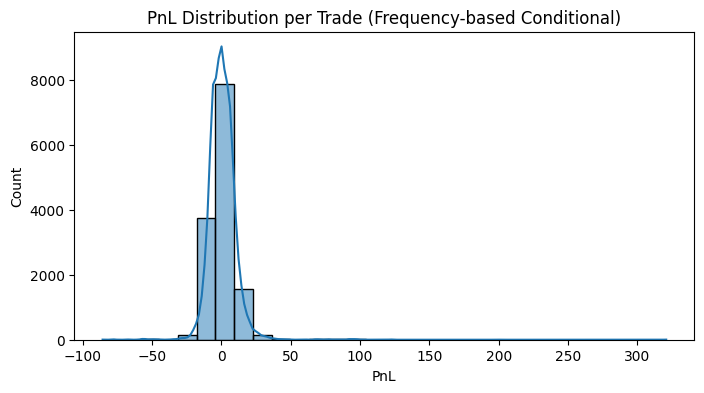

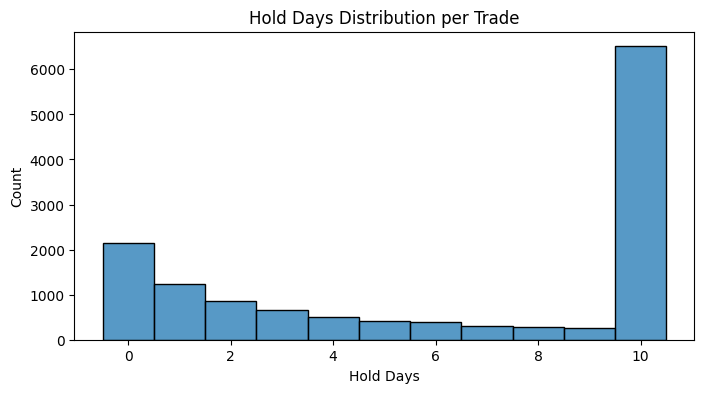

               pnl  hold_days
mean      0.698251   6.138338
median    0.020000   8.000000
std      10.244669   4.185349
min     -85.710000   0.000000
max     320.800000  10.000000
Fraction of trades sold by hold days:
 hold_days
0     0.157658
1     0.091070
2     0.062901
3     0.048448
4     0.037239
5     0.031340
6     0.028316
7     0.023007
8     0.020647
9     0.019394
10    0.479979
Name: count, dtype: float64
Average PnL - naive 5-day hold: 5.18454
Average PnL - frequency-based conditional: 0.6982508664552761


In [151]:
import matplotlib.pyplot as plt
import seaborn as sns

# PnL distribution
plt.figure(figsize=(8,4))
sns.histplot(results_conditional['pnl'], bins=30, kde=True)
plt.title("PnL Distribution per Trade (Frequency-based Conditional)")
plt.xlabel("PnL")
plt.ylabel("Count")
plt.show()

# Hold duration distribution
plt.figure(figsize=(8,4))
sns.histplot(results_conditional['hold_days'], bins=range(0,11), discrete=True)
plt.title("Hold Days Distribution per Trade")
plt.xlabel("Hold Days")
plt.ylabel("Count")
plt.show()
summary_stats = results_conditional.agg({
    'pnl': ['mean', 'median', 'std', 'min', 'max'],
    'hold_days': ['mean', 'median', 'std', 'min', 'max']
})
print(summary_stats)
sell_day_counts = results_conditional['hold_days'].value_counts().sort_index()
sell_day_counts = sell_day_counts / sell_day_counts.sum()
print("Fraction of trades sold by hold days:\n", sell_day_counts)
# Assuming results_naive is available
print("Average PnL - naive 5-day hold:", results_naive['PnL_$'].mean())
print("Average PnL - frequency-based conditional:", results_conditional['pnl'].mean())



In [ ]:
mask = y_train == 1